In [1]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# Kaggle dataset base line: ResNet50 finetuning
Check for GPU

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [3]:
data_dir = "./real-dataset-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   preprocessing_function=keras.applications.resnet50.preprocess_input,
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [5]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training',
                                                    class_mode='categorical')
img_train

Found 14430 images belonging to 5 classes.


Get test data

In [6]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation',
                                                    class_mode='categorical')
img_test

Found 3605 images belonging to 5 classes.


Load ResNet50

(approach taken from: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b)

In [7]:
input_tensor = keras.Input(shape=(image_height,image_width,nr_color_channels))
resnet50_model = keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_tensor)

Freeze layers apart from last block 

In [8]:
for layer in resnet50_model.layers[:134]:
    layer.trainable = False

Add new layers

In [9]:
model = keras.models.Sequential()
model.add(resnet50_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5,activation='softmax'))

Create model checkpoints

In [10]:
filepath = "./" + 'models/CIFAR10/CIFAR10_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [11]:
callbacks_list = [check_point]

In [12]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [13]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
901/901 [==============================] - 235s 249ms/step - loss: 2.0636 - accuracy: 0.2377 - val_loss: 1.5277 - val_accuracy: 0.3100

Epoch 00001: val_accuracy improved from -inf to 0.31000, saving model to ./models/CIFAR10\CIFAR10_01-0.3100.hdf5


c:\Users\selin\miniconda3\envs\cov-project\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
901/901 [==============================] - 158s 175ms/step - loss: 1.9634 - accuracy: 0.2546 - val_loss: 1.5102 - val_accuracy: 0.3939

Epoch 00002: val_accuracy improved from 0.31000 to 0.39389, saving model to ./models/CIFAR10\CIFAR10_02-0.3939.hdf5
Epoch 3/25
901/901 [==============================] - 157s 174ms/step - loss: 1.8911 - accuracy: 0.2797 - val_loss: 1.4173 - val_accuracy: 0.4056

Epoch 00003: val_accuracy improved from 0.39389 to 0.40556, saving model to ./models/CIFAR10\CIFAR10_03-0.4056.hdf5
Epoch 4/25
901/901 [==============================] - 156s 173ms/step - loss: 1.8103 - accuracy: 0.3062 - val_loss: 1.3387 - val_accuracy: 0.5053

Epoch 00004: val_accuracy improved from 0.40556 to 0.50528, saving model to ./models/CIFAR10\CIFAR10_04-0.5053.hdf5
Epoch 5/25
901/901 [==============================] - 157s 174ms/step - loss: 1.7582 - accuracy: 0.3202 - val_loss: 1.2527 - val_accuracy: 0.5147

Epoch 00005: val_accuracy improved from 0.50528 to 0.51472, savi

KeyboardInterrupt: 

Evaluate model

In [88]:
pred = model.predict(img_test, steps=len(img_test.filenames))

In [89]:
evaluate_classification_result(img_test.classes, pred, classes=["Foggy","Cloudy","Sunny","Snowy","Rainy"])

[[3 1 0 4 2]
 [6 1 1 1 1]
 [1 2 0 4 3]
 [1 1 0 2 6]
 [4 4 0 0 2]]


Class Foggy:
    Sensitivity (TPR):  30.000% (3 of 10)
    Specificity (TNR):  70.000% (28 of 40)
    Precision:          20.000% (3 of 15)
    Neg. pred. value:   80.000% (28 of 35)
Class Cloudy:
    Sensitivity (TPR):  10.000% (1 of 10)
    Specificity (TNR):  80.000% (32 of 40)
    Precision:          11.111% (1 of 9)
    Neg. pred. value:   78.049% (32 of 41)
Class Sunny:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR):  97.500% (39 of 40)
    Precision:           0.000% (0 of 1)
    Neg. pred. value:   79.592% (39 of 49)
Class Snowy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  77.500% (31 of 40)
    Precision:          18.182% (2 of 11)
    Neg. pred. value:   79.487% (31 of 39)
Class Rainy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  70.000% (28 of 40)
    Precision:          14.286% (2 of 14)
    Neg. pred. value:   77.778% (28 of 36)

Overall accuracy:

array([[3, 1, 0, 4, 2],
       [6, 1, 1, 1, 1],
       [1, 2, 0, 4, 3],
       [1, 1, 0, 2, 6],
       [4, 4, 0, 0, 2]], dtype=int64)

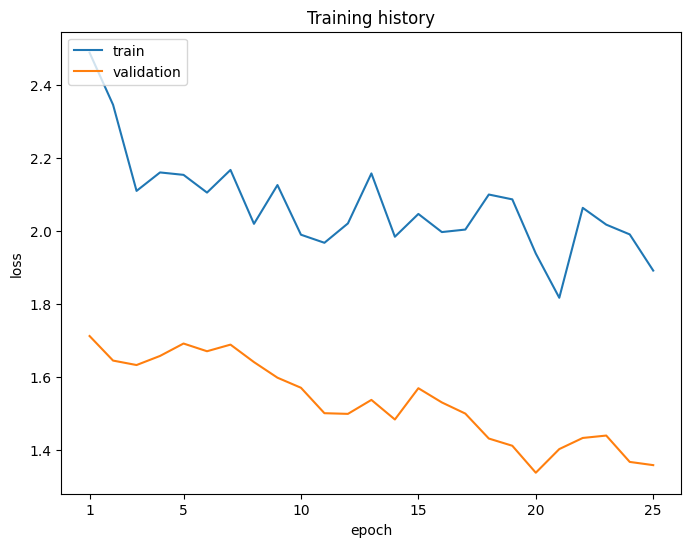

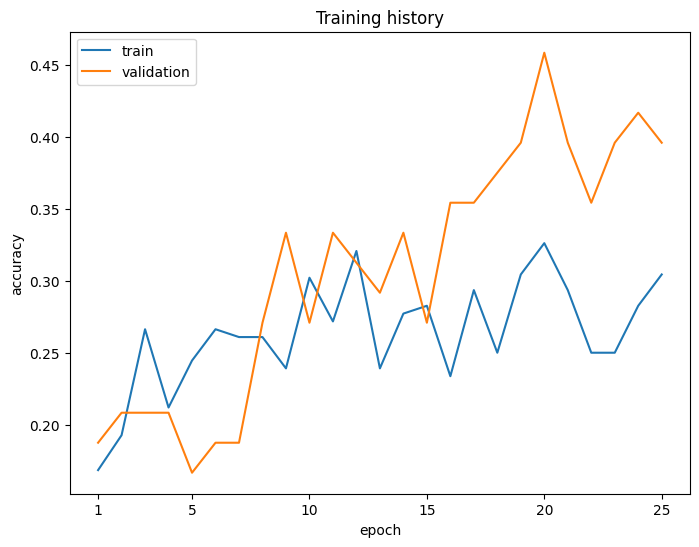

In [90]:
plot_history(history)

In [14]:
model = keras.models.load_model(".\models\CIFAR10\CIFAR10_16-0.5964.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

In [15]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[690  33   0  84 533]
 [126   6   0  21  99]
 [193   9   0  20 163]
 [188   6   0  30 150]
 [644  36   0  86 488]]


Class foggy:
    Sensitivity (TPR):  51.493% (690 of 1340)
    Specificity (TNR):  49.183% (1114 of 2265)
    Precision:          37.480% (690 of 1841)
    Neg. pred. value:   63.152% (1114 of 1764)
Class cloudy:
    Sensitivity (TPR):   2.381% (6 of 252)
    Specificity (TNR):  97.495% (3269 of 3353)
    Precision:           6.667% (6 of 90)
    Neg. pred. value:   93.001% (3269 of 3515)
Class sunny:
    Sensitivity (TPR):   0.000% (0 of 385)
    Specificity (TNR): 100.000% (3220 of 3220)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   89.320% (3220 of 3605)
Class snowy:
    Sensitivity (TPR):   8.021% (30 of 374)
    Specificity (TNR):  93.470% (3020 of 3231)
    Precision:          12.448% (30 of 241)
    Neg. pred. value:   89.774% (3020 of 3364)
Class rainy:
    Sensitivity (TPR):  38.915% (488 of 1254)
    Specificity (TNR):  59.804% (1406 of 2351

c:\Users\selin\Desktop\cov-project\cov-project\pyMLaux\functions.py:148: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)


array([[690,  33,   0,  84, 533],
       [126,   6,   0,  21,  99],
       [193,   9,   0,  20, 163],
       [188,   6,   0,  30, 150],
       [644,  36,   0,  86, 488]], dtype=int64)